# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
from tf_config import tf_config
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


### Let's visualize one series(video) of each class

See one sequence of each class, instead of 30 only 7 images will be displayed. These 7 images are selected uniformaly

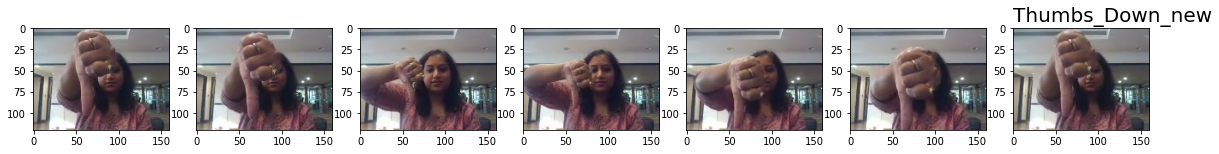

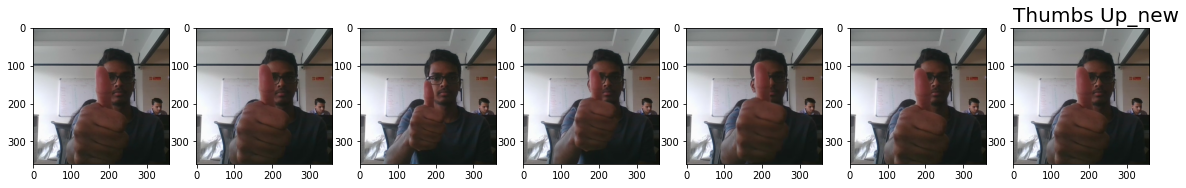

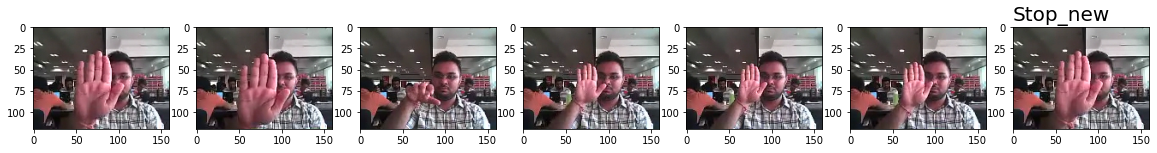

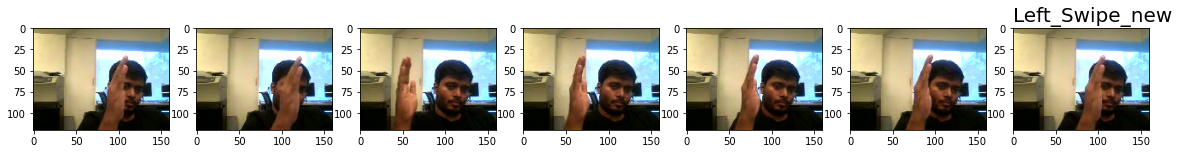

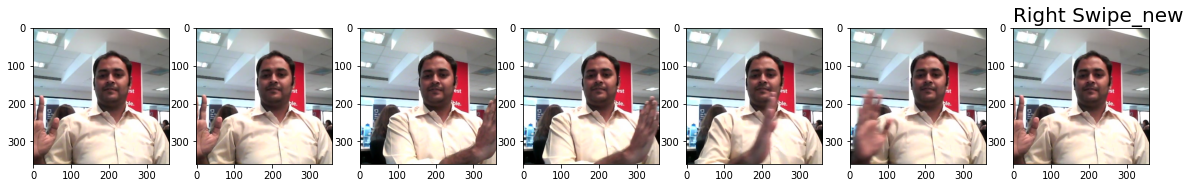

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Utility function to display one complete series (sampled not all 30 sequences)
def display_one_seq(path, title, img_idx):
    num_sub_plot = len(img_idx)
    imgs = os.listdir(image_path)
    # create subplot
    f, axarr = plt.subplots(1,7,figsize=(20,5))
    # set title
    plt.title(title,fontsize=20,loc='left')
    # plot all
    for i in range(len(img_idx)):
        image = imread(image_path + '/'+imgs[img_idx[i]])
        axarr[i].imshow(image)
    plt.show()

# Temporary list to store the class index
temp_list = []

# image indexes to display 
img_idx = [0,5,10,15,20,25,29]

# loop for all the classes in the dataset
for doc in val_doc:
    idx = int(doc.split(';')[2])
    
    if idx not in temp_list:
        image_path = val_path +'/'+ doc.split(';')[0]
        title = doc.split(';')[1]
        display_one_seq(val_path, title, img_idx)
        temp_list.append(idx)
    if len(temp_list) == 5:
        break

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

As a part of generator, also added data augmentation

In [7]:
# import cv2 for data augmentaion 
import cv2

# data generator function
def generator(source_path, folder_list, batch_size, target_witdth = 120, target_height = 120, img_idx = None, augment = False):

    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    if img_idx is None:
        img_idx = np.arange(0,30,1) #create a list of image numbers you want to use for a particular video
        
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        
        x = len(img_idx) # the number of images you use for each video
        y = target_height # height of image
        z = target_witdth # width of image
            
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

            if (augment): 
                batch_data_aug = np.zeros((batch_size,x,y,z,3))

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    # read Image and conevrt to float
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = resize(image,(y,z,3))
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the image
                    
                    # Augmenation code
                    if (augment):
                        shifted = cv2.warpAffine(image, 
                                                 np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                                 (image.shape[1], image.shape[0]))
                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
                        
                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                        
                        cropped=shifted[x0:x1,y0:y1,:]
                        image_resized=resize(cropped,(y,z,3))
                        
                        batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            if (augment):
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # get left over data
        batch_size_left = int(len(folder_list) % batch_size)
        batch = num_batches
        
        # if there is left over data form a batch
        if batch_size_left > 0:
            # write the code for the remaining data points which are left after full batches
            batch_data = np.zeros((batch_size_left,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size_left,5)) # batch_labels is the one hot representation of the output
            
            if (augment): 
                batch_data_aug = np.zeros((batch_size_left,x,y,z,3))

            for folder in range(batch_size_left): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    # read Image and conevrt to float
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized=resize(image,(y,z,3))

                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the image
                    
                    # Augmenation code
                    if (augment):
                        shifted = cv2.warpAffine(image, 
                                                 np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                                 (image.shape[1], image.shape[0]))
                        
                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
                        
                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                        cropped=shifted[x0:x1,y0:y1,:]
                        
                        image_resized=resize(cropped,(y,z,3))
                        
                        batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            if (augment):
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

### Utility function to plot model history

In [8]:
def plot(history):
    '''
    Plot Train and Validation graphs from model train history
    '''
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Model 1 : Conv3D simple
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

In [10]:
# HyperParameters 
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# input shape and num of frmaes to be picked
ImageWidth = 120
ImageHeight = 120
print("ImageWidth : ",ImageWidth)
print("ImageHeight : ",ImageHeight)

# Number of images to be used for train or validation 
img_idx = np.arange(0,30,1)
seq_len = len(img_idx)
print("seq_len : ",seq_len)

# epochs = 15
ImageWidth :  120
ImageHeight :  120
seq_len :  30


In [11]:
#write your model here
model = Sequential([
  Conv3D(16, (3,3,3), padding='same', activation='relu',input_shape=(seq_len, ImageHeight, ImageWidth, 3)),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Conv3D(32, (3,3,3), padding='same', activation='relu'),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Conv3D(64, (3,3,3), padding='same', activation='relu'),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(5, activation='softmax')
])


2022-11-15 00:51:29.488285: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-15 00:51:29.488361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
optimiser = "adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 7, 30, 30, 32)    0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 7, 30, 30, 64)     55360     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 3, 15, 15, 64)    0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size, ImageWidth, ImageHeight, img_idx)
val_generator = generator(val_path, val_doc, batch_size, ImageWidth, ImageHeight, img_idx)

In [13]:
# Model Path
model_name = 'model_cnn3D_1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Model File name
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# model checkpoints
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period = 1)

# callbacks 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint,LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15


2022-11-14 15:48:02.024267: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.8032 - categorical_accuracy: 0.1961Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_cnn3D_1_2022-11-1415_47_45.769157/model-00001-1.80319-0.19608-1.56131-0.23000.h5
21/21 [==============================] - 179s 9s/step - loss: 1.8032 - categorical_accuracy: 0.1961 - val_loss: 1.5613 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.5155 - categorical_accuracy: 0.3107
Epoch 00002: saving model to model_cnn3D_1_2022-11-1415_47_45.769157/model-00002-1.51545-0.31071-1.29707-0.39000.h5
21/21 [==============================] - 162s 8s/step - loss: 1.5155 - categorical_accuracy: 0.3107 - val_loss: 1.2971 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.1707 - categorical_accuracy: 0.5309
Epoch 00003: saving model to model_cnn3D_1_2022-11-1415_47_45.

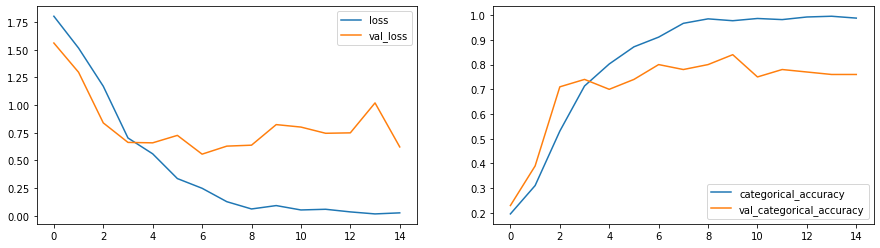

In [16]:
plot(history)

 ** Model is overfitted, we can easily see a huge gap in Train and Validation Acuuracy **

Let's Build new model with adding some techinques to remove the overfitting.

To start with lets add **Dropout**

## Model 2 : Adding Dropout (Model 1 + Dropout)

Here we will be using Conv3d and Dropout layers to sole the overfitting issue

In [17]:
# Hyperparameters
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
# input shape and num of frmaes to be picked
ImageWidth = 120
print("ImageWidth : ",ImageWidth)
ImageHeight = 120
print("ImageHeight : ",ImageHeight)
img_idx = np.arange(0,30,1)
seq_len = len(img_idx)
print("seq_len : ",seq_len)
# Generators
train_generator = generator(train_path, train_doc, batch_size, ImageWidth, ImageHeight, img_idx)
val_generator = generator(val_path, val_doc, batch_size, ImageWidth, ImageHeight, img_idx)

# epochs = 15
ImageWidth :  120
ImageHeight :  120
seq_len :  30


In [18]:
# create one dir
model_name = 'model_cnn3D_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

# model name 
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period = 1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,min_lr=0.001) 
callbacks_list = [checkpoint, LR]

#write your model here
model = Sequential([
  Conv3D(16, (3,3,3), padding='same', activation='relu',input_shape=(seq_len, ImageHeight, ImageWidth, 3)),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Dropout(0.2),
  Conv3D(32, (3,3,3), padding='same', activation='relu'),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Dropout(0.2),
  Conv3D(64, (3,3,3), padding='same', activation='relu'),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(0.2),
  Dense(5, activation='softmax')
])

#write your optimizer
optimiser = "adam" 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 dropout (Dropout)           (None, 15, 60, 60, 16)    0         
                                                                 
 conv3d_4 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 7, 30, 30, 32)    0         
 3D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 30, 30, 32)    

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 2.2595 - categorical_accuracy: 0.1885Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_cnn3D_2_2022-11-1415_47_45.769157/model-00001-2.25952-0.18854-1.60932-0.22000.h5
21/21 [==============================] - 167s 8s/step - loss: 2.2595 - categorical_accuracy: 0.1885 - val_loss: 1.6093 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.6090 - categorical_accuracy: 0.1825
Epoch 00002: saving model to model_cnn3D_2_2022-11-1415_47_45.769157/model-00002-1.60901-0.18250-1.59880-0.29000.h5
21/21 [==============================] - 167s 8s/step - loss: 1.6090 - categorical_accuracy: 0.1825 - val_loss: 1.5988 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.5150 - categorical_a

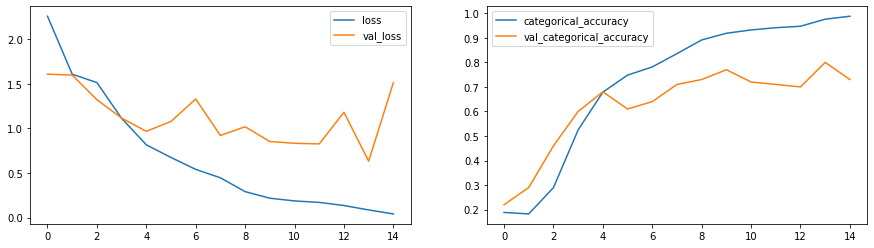

In [19]:
# Train current model 
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot history
plot(history)

** We managed to reduce the Train and Validation gap, however model is still overfitting **

Let's try ** BatchNormalization **

## Model 3 : Adding Dropout (Model 2 + BatchNormalization)

Here we will be using BatchNormalization along with Conv3d and Dropout to reduce the ovrfitting

In [20]:
# Hyperparameters
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
# input shape and num of frmaes to be picked
ImageWidth = 120
print("ImageWidth : ",ImageWidth)
ImageHeight = 120
print("ImageHeight : ",ImageHeight)
img_idx = np.arange(0,30,1)
seq_len = len(img_idx)
print("seq_len : ",seq_len)
# Generators
train_generator = generator(train_path, train_doc, batch_size, ImageWidth, ImageHeight, img_idx)
val_generator = generator(val_path, val_doc, batch_size, ImageWidth, ImageHeight, img_idx)

# epochs = 15
ImageWidth :  120
ImageHeight :  120
seq_len :  30


In [21]:
# create one dir
model_name = 'model_cnn3D_3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

# model name 
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period = 1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,min_lr=0.001) 
callbacks_list = [checkpoint, LR]

#write your model here
model = Sequential([
  Conv3D(16, (3,3,3), padding='same', activation='relu',input_shape=(seq_len, ImageHeight, ImageWidth, 3)),
  BatchNormalization(),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Dropout(0.2),

  Conv3D(32, (3,3,3), padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Dropout(0.2),

  Conv3D(64, (3,3,3), padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Dropout(0.2),

  Flatten(),

  Dense(128, activation='relu'),
  BatchNormalization(),
  Dropout(0.2),
    
  Dense(5, activation='softmax')
])

#write your optimizer
optimiser = "adam" 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 15, 60, 60, 16)    0         
                                                                 
 conv3d_7 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                                 
 batch_normalization_1 (Batc  (None, 15, 60, 60, 32)  

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 1.1822 - categorical_accuracy: 0.5928Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_cnn3D_3_2022-11-1415_47_45.769157/model-00001-1.18219-0.59276-4.56520-0.16000.h5
21/21 [==============================] - 165s 8s/step - loss: 1.1822 - categorical_accuracy: 0.5928 - val_loss: 4.5652 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 0.4095 - categorical_accuracy: 0.8220
Epoch 00002: saving model to model_cnn3D_3_2022-11-1415_47_45.769157/model-00002-0.40951-0.82202-7.11551-0.18000.h5
21/21 [==============================] - 164s 8s/step - loss: 0.4095 - categorical_accuracy: 0.8220 - val_loss: 7.1155 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.1902 - categorical_a

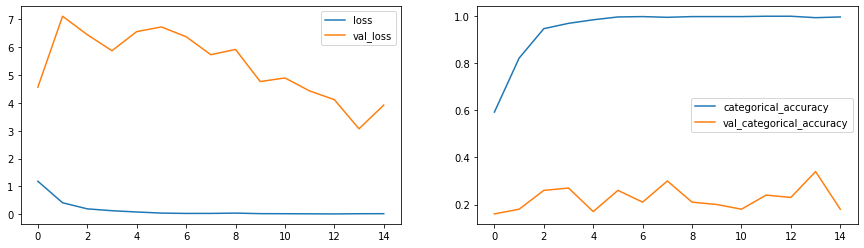

In [22]:
# Train current model 
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot history
plot(history)

** Batch Normalization didn't help here **

let's try **Data Augmentation ** and Re-train the model

## Model 4 : Adding Data Augmentation

No change in the Model, but we will be doing data augmentaion randomly.

In [23]:
# Hyperparameters
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# input shape and num of frmaes to be picked
ImageWidth = 120
ImageHeight = 120
print("ImageWidth : ",ImageWidth)
print("ImageHeight : ",ImageHeight)

# input image sequence
img_idx = np.arange(0,30,1)
seq_len = len(img_idx)
print("seq_len : ",seq_len)

# Generators with Augmenation for train data 
data_augmentation = True
train_generator = generator(train_path, train_doc, batch_size, ImageWidth, ImageHeight, img_idx, data_augmentation)
val_generator = generator(val_path, val_doc, batch_size, ImageWidth, ImageHeight, img_idx)

# epochs = 15
ImageWidth :  120
ImageHeight :  120
seq_len :  30


In [24]:
# create one dir
model_name = 'model_cnn3D_4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

# model name 
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period = 1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,min_lr=0.001) 
callbacks_list = [checkpoint, LR]

#write your model here
model = Sequential([
  Conv3D(16, (3,3,3), padding='same', activation='relu',input_shape=(seq_len, ImageHeight, ImageWidth, 3)),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Dropout(0.2),

  Conv3D(32, (3,3,3), padding='same', activation='relu'),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Dropout(0.2),

  Conv3D(64, (3,3,3), padding='same', activation='relu'),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Dropout(0.2),

  Flatten(),

  Dense(128, activation='relu'),
  Dropout(0.2),
    
  Dense(5, activation='softmax')
])

#write your optimizer
optimiser = "adam" 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 15, 60, 60, 16)    0         
                                                                 
 conv3d_10 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 7, 30, 30, 32)    0         
 g3D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 7, 30, 30, 32)    

In [ ]:
# Train current model 
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot history
plot(history)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 2.8806 - categorical_accuracy: 0.1923 Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_cnn3D_4_2022-11-1415_47_45.769157/model-00001-2.88056-0.19231-1.60882-0.22000.h5
21/21 [==============================] - 295s 15s/step - loss: 2.8806 - categorical_accuracy: 0.1923 - val_loss: 1.6088 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.1961 
Epoch 00002: saving model to model_cnn3D_4_2022-11-1415_47_45.769157/model-00002-1.60941-0.19608-1.60860-0.19000.h5
21/21 [==============================] - 291s 15s/step - loss: 1.6094 - categorical_accuracy: 0.1961 - val_loss: 1.6086 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.6093 - categoric

Lets add more layer as model is under performing 

## Model 5: Adding layers

In [ ]:
# reduce batch, to avoid memory issue
batch_size = 16

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Hyperparameters
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
# input shape and num of frmaes to be picked
ImageWidth = 120
print("ImageWidth : ",ImageWidth)
ImageHeight = 120
print("ImageHeight : ",ImageHeight)
img_idx = np.arange(0,30,1)
seq_len = len(img_idx)
print("seq_len : ",seq_len)
# Generators
train_generator = generator(train_path, train_doc, batch_size, ImageWidth, ImageHeight, img_idx)
val_generator = generator(val_path, val_doc, batch_size, ImageWidth, ImageHeight, img_idx)

In [ ]:
# create one dir
model_name = 'model_cnn3D_5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

# model name 
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period = 1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,min_lr=0.001) 
callbacks_list = [checkpoint, LR]

#write your model here
model = Sequential([
  Conv3D(16, (3,3,3), padding='same', activation='relu',input_shape=(seq_len, ImageHeight, ImageWidth, 3)),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Dropout(0.2),

  Conv3D(64, (3,3,3), padding='same', activation='relu'),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Dropout(0.2),

  Conv3D(64, (3,3,3), padding='same', activation='relu'),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Dropout(0.2),

  Conv3D(64, (2,2,2), padding='same', activation='relu'),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Dropout(0.2),

  Flatten(),

  Dense(128, activation='relu'),
  Dropout(0.2),
    
  Dense(5, activation='softmax')
])

#write your optimizer
optimiser = "adam" 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
# Train current model 
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot history
plot(history)

This model seems to be good, we have reducded overfitting. But still we are using all the 30 input sequences to train, let's train the model by reducing the input number of ** sequence to 15 **

## Model 6 : Train with less number of input sequence

In [ ]:
# reduce batch, to avoid memory issue
batch_size = 16

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Hyperparameters
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
# input shape and num of frmaes to be picked
ImageWidth = 120
print("ImageWidth : ",ImageWidth)
ImageHeight = 120
print("ImageHeight : ",ImageHeight)
img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,29]
seq_len = len(img_idx)
print("seq_len : ",seq_len)
# Generators
data_augmentation = True
train_generator = generator(train_path, train_doc, batch_size, ImageWidth, ImageHeight, img_idx, data_augmentation)
val_generator = generator(val_path, val_doc, batch_size, ImageWidth, ImageHeight, img_idx)

In [ ]:
# create one dir
model_name = 'model_cnn3D_6' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

# model name 
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period = 1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,min_lr=0.001) 
callbacks_list = [checkpoint, LR]

#write your model here
model = Sequential([
  Conv3D(16, (3,3,3), padding='same', activation='relu',input_shape=(seq_len, ImageHeight, ImageWidth, 3)),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Dropout(0.2),

  Conv3D(64, (3,3,3), padding='same', activation='relu'),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Dropout(0.2),

  Conv3D(64, (3,3,3), padding='same', activation='relu'),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Dropout(0.2),

  Conv3D(64, (2,2,2), padding='same', activation='relu'),
  MaxPooling3D(pool_size=(2, 2, 2)),
  Dropout(0.2),

  Flatten(),

  Dense(128, activation='relu'),
  Dropout(0.2),
    
  Dense(5, activation='softmax')
])

#write your optimizer
optimiser = "adam" 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
# Train current model 
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot history
plot(history)

By using the Conv3D we were able to achieve good accuracy, and even we have reduced the overfitting.

** Next Let's try out some CNN + RNN model, and If we can do better **

### Let's Import required layers

In [15]:
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM

Let's reduce the batch_size to 16, as we don't have enough memory for 32

In [16]:
batch_size = 16

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

## Model 7 : Simple CNN + LSTM

to start with let's have some layers of Conv2D and LSTM cells

In [ ]:
# Hyperparameters
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
# input shape and num of frmaes to be picked
ImageWidth = 120
print("ImageWidth : ",ImageWidth)
ImageHeight = 120
print("ImageHeight : ",ImageHeight)

# take all picture and trian
img_idx = np.arange(0,30,1)
seq_len = len(img_idx)
print("seq_len : ",seq_len)

# Generators
data_augmentation = False
train_generator = generator(train_path, train_doc, batch_size, ImageWidth, ImageHeight, img_idx, data_augmentation)
val_generator = generator(val_path, val_doc, batch_size, ImageWidth, ImageHeight, img_idx)

In [ ]:
model_name = 'model_rnn_cnn_7' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period = 1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint,LR]

In [ ]:
#write your model here
model = Sequential([
    TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                    input_shape=(seq_len, ImageHeight, ImageWidth, 3)),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Dropout(0.2)),
    
    TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Dropout(0.2)),
    
    TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Dropout(0.2)),
    
    TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Dropout(0.2)),
    
    TimeDistributed(Flatten()),
    
    LSTM(64),
    Dropout(0.2),
    
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

#write your optimizer
optimiser = "adam" 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
# Train current model 
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot history
plot(history)

Model is overfitting, we can easily a gap in train and validation accuracy. 

Next lets see performance of GRU

## Model 8 : mobilenet + GRU

In [ ]:
# Hyperparameters
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
# input shape and num of frmaes to be picked
ImageWidth = 120
print("ImageWidth : ",ImageWidth)
ImageHeight = 120
print("ImageHeight : ",ImageHeight)

# take all picture and trian
img_idx = np.arange(0,30,1)
seq_len = len(img_idx)
print("seq_len : ",seq_len)

# Generators
data_augmentation = False
train_generator = generator(train_path, train_doc, batch_size, ImageWidth, ImageHeight, img_idx, data_augmentation)
val_generator = generator(val_path, val_doc, batch_size, ImageWidth, ImageHeight, img_idx)

In [ ]:
model_name = 'model_rnn_cnn_8' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period = 1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint,LR]

In [ ]:
#write your model here
model = Sequential([
    TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                    input_shape=(seq_len, ImageHeight, ImageWidth, 3)),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Dropout(0.2)),
    
    TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Dropout(0.2)),
    
    TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Dropout(0.2)),
    
    TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Dropout(0.2)),
    
    TimeDistributed(Flatten()),
    
    GRU(128),
    Dropout(0.2),
    
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

#write your optimizer
optimiser = "adam" 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
# Train current model 
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot history
plot(history)

Here also it is Overfitting,  

Next lets use transfer learning. Here we will be using "mobilenet" architecture along with weights from 'imagenet'

## Model 9 : mobilenet + LSTM (Transfer Learning)

In [ ]:
# Hyperparameters
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
# input shape and num of frmaes to be picked
ImageWidth = 120
print("ImageWidth : ",ImageWidth)
ImageHeight = 120
print("ImageHeight : ",ImageHeight)

# take all picture and trian
img_idx = np.arange(0,30,1)
seq_len = len(img_idx)
print("seq_len : ",seq_len)

# Generators
data_augmentation = False
train_generator = generator(train_path, train_doc, batch_size, ImageWidth, ImageHeight, img_idx, data_augmentation)
val_generator = generator(val_path, val_doc, batch_size, ImageWidth, ImageHeight, img_idx)

In [ ]:
model_name = 'model_rnn_cnn_9' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period = 1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint,LR]

In [ ]:
from tensorflow.keras.applications import mobilenet

mobilenet_trns = mobilenet.MobileNet(weights='imagenet', include_top=False)

#write your model here
model = Sequential([
    TimeDistributed(mobilenet_trns,input_shape=(seq_len, ImageHeight, ImageWidth, 3)),
    
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    TimeDistributed(Dropout(0.2)),
    
    LSTM(64),
    Dropout(0.2),
    
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

# freeze weights
for layer in mobilenet_trns.layers:
    layer.trainable = False

#write your optimizer
optimiser = "adam" 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
# Train current model 
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot history
plot(history)

Model is better , but again over fitted.

Next lets check Transfer learning with GRU

## Model 10 : mobilenet + GRU (Transfer Learning)

In [ ]:
# Hyperparameters
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
# input shape and num of frmaes to be picked
ImageWidth = 120
print("ImageWidth : ",ImageWidth)
ImageHeight = 120
print("ImageHeight : ",ImageHeight)

# take all picture and trian
img_idx = np.arange(0,30,1)
seq_len = len(img_idx)
print("seq_len : ",seq_len)

# Generators
data_augmentation = False
train_generator = generator(train_path, train_doc, batch_size, ImageWidth, ImageHeight, img_idx, data_augmentation)
val_generator = generator(val_path, val_doc, batch_size, ImageWidth, ImageHeight, img_idx)

In [ ]:
model_name = 'model_rnn_cnn_10' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period = 1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint,LR]

In [ ]:
from tensorflow.keras.applications import mobilenet

mobilenet_trns = mobilenet.MobileNet(weights='imagenet', include_top=False)

#write your model here
model = Sequential([
    TimeDistributed(mobilenet_trns,input_shape=(seq_len, ImageHeight, ImageWidth, 3)),
    
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    TimeDistributed(Dropout(0.2)),
    
    GRU(128),
    Dropout(0.2),
    
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

# freeze weights
for layer in mobilenet_trns.layers:
    layer.trainable = False

#write your optimizer
optimiser = "adam" 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
# Train current model 
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot history
plot(history)

Model is better, Overfitting is still there.

Next lets try data augmentation and see results

## Model 11 : mobilenet + GRU (Model 10 + data augmentation)

In [ ]:
# Hyperparameters
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
# input shape and num of frmaes to be picked
ImageWidth = 120
print("ImageWidth : ",ImageWidth)
ImageHeight = 120
print("ImageHeight : ",ImageHeight)

# take all picture and trian
img_idx = np.arange(0,30,1)
seq_len = len(img_idx)
print("seq_len : ",seq_len)

# Generators
data_augmentation = True
train_generator = generator(train_path, train_doc, batch_size, ImageWidth, ImageHeight, img_idx, data_augmentation)
val_generator = generator(val_path, val_doc, batch_size, ImageWidth, ImageHeight, img_idx)

In [ ]:
model_name = 'model_rnn_cnn_11' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period = 1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint,LR]

In [ ]:
from tensorflow.keras.applications import mobilenet

mobilenet_trns = mobilenet.MobileNet(weights='imagenet', include_top=False)

#write your model here
model = Sequential([
    TimeDistributed(mobilenet_trns,input_shape=(seq_len, ImageHeight, ImageWidth, 3)),
    
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    TimeDistributed(Dropout(0.2)),
    
    GRU(128),
    Dropout(0.2),
    
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

# freeze weights
for layer in mobilenet_trns.layers:
    layer.trainable = False

#write your optimizer
optimiser = "adam" 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
# Train current model 
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot history
plot(history)

Model is good and we have reduced the gap between train and validation accuricies.

Next lets try to train the full model to chack if we can improve on this further

## Model 12 : mobilenet + GRU (Model 11 + Full training)

In [17]:
# Hyperparameters
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
# input shape and num of frmaes to be picked
ImageWidth = 120
print("ImageWidth : ",ImageWidth)
ImageHeight = 120
print("ImageHeight : ",ImageHeight)

# take all picture and trian
img_idx = np.arange(0,30,1)
seq_len = len(img_idx)
print("seq_len : ",seq_len)

# Generators
data_augmentation = False
train_generator = generator(train_path, train_doc, batch_size, ImageWidth, ImageHeight, img_idx, data_augmentation)
val_generator = generator(val_path, val_doc, batch_size, ImageWidth, ImageHeight, img_idx)

# epochs = 15
ImageWidth :  120
ImageHeight :  120
seq_len :  30


In [18]:
model_name = 'model_rnn_cnn_12' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period = 1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint,LR]

In [19]:
from tensorflow.keras.applications import mobilenet

mobilenet_trns = mobilenet.MobileNet(weights='imagenet', include_top=False)

#write your model here
model = Sequential([
    TimeDistributed(mobilenet_trns,input_shape=(seq_len, ImageHeight, ImageWidth, 3)),
    
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    TimeDistributed(Dropout(0.2)),
    
    GRU(128),
    Dropout(0.2),
    
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

# freeze weights
#for layer in mobilenet_trns.layers:
#    layer.trainable = False

#write your optimizer
optimiser = "adam" 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 1024)         0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 1024)        

Source path =  /home/datasets/Project_data/train ; batch size = 16
Epoch 1/15


2022-11-15 00:57:06.163497: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


42/42 [==============================] - ETA: 0s - loss: 1.1152 - categorical_accuracy: 0.5535Source path =  /home/datasets/Project_data/val ; batch size = 16

Epoch 00001: saving model to model_rnn_cnn_12_2022-11-1500_50_41.224356/model-00001-1.11520-0.55354-0.71956-0.73000.h5
42/42 [==============================] - 163s 4s/step - loss: 1.1152 - categorical_accuracy: 0.5535 - val_loss: 0.7196 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 2/15
42/42 [==============================] - ETA: 0s - loss: 0.3861 - categorical_accuracy: 0.8658
Epoch 00002: saving model to model_rnn_cnn_12_2022-11-1500_50_41.224356/model-00002-0.38612-0.86576-0.46240-0.74000.h5
42/42 [==============================] - 156s 4s/step - loss: 0.3861 - categorical_accuracy: 0.8658 - val_loss: 0.4624 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 3/15
42/42 [==============================] - ETA: 0s - loss: 0.2543 - categorical_accuracy: 0.9095
Epoch 00003: saving model to model_rnn_cnn_12_2022-11-15

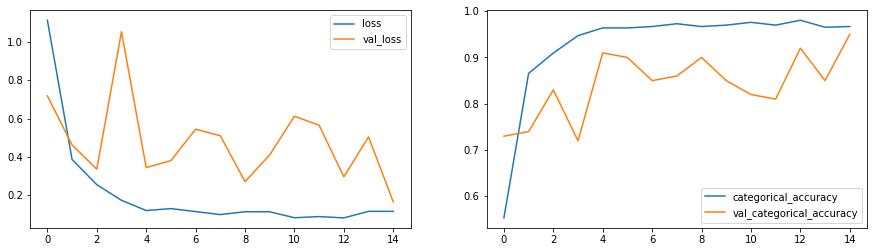

In [20]:
# Train current model 
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot history
plot(history)

Model is good, even overfitting is not there.

But we are using all 30 sequences, Let's reduce the input number of sequences to 15 and re-train

## Model 13 : mobilenet + GRU (Model 12 + 15-Sequence)

In [21]:
# Hyperparameters
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
# input shape and num of frmaes to be picked
ImageWidth = 120
print("ImageWidth : ",ImageWidth)
ImageHeight = 120
print("ImageHeight : ",ImageHeight)

# take all picture and trian
img_idx = np.arange(0,30,2)
seq_len = len(img_idx)
print("seq_len : ",seq_len)

# Generators
data_augmentation = False
train_generator = generator(train_path, train_doc, batch_size, ImageWidth, ImageHeight, img_idx, data_augmentation)
val_generator = generator(val_path, val_doc, batch_size, ImageWidth, ImageHeight, img_idx)

# epochs = 20
ImageWidth :  120
ImageHeight :  120
seq_len :  15


In [22]:
model_name = 'model_rnn_cnn_13' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period = 1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint,LR]

In [23]:
from tensorflow.keras.applications import mobilenet

mobilenet_trns = mobilenet.MobileNet(weights='imagenet', include_top=False)

#write your model here
model = Sequential([
    TimeDistributed(mobilenet_trns,input_shape=(seq_len, ImageHeight, ImageWidth, 3)),
    
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    TimeDistributed(Dropout(0.2)),
    
    GRU(128),
    Dropout(0.2),
    
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

#write your optimizer
optimiser = "adam" 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  (None, 15, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 15, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 15, 1024)         0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 15, 1024)        

Source path =  /home/datasets/Project_data/train ; batch size = 16
Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 1.1129 - categorical_accuracy: 0.5294Source path =  /home/datasets/Project_data/val ; batch size = 16

Epoch 00001: saving model to model_rnn_cnn_13_2022-11-1500_50_41.224356/model-00001-1.11290-0.52941-0.82027-0.64000.h5
42/42 [==============================] - 84s 2s/step - loss: 1.1129 - categorical_accuracy: 0.5294 - val_loss: 0.8203 - val_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 0.3523 - categorical_accuracy: 0.8688
Epoch 00002: saving model to model_rnn_cnn_13_2022-11-1500_50_41.224356/model-00002-0.35232-0.86878-0.66758-0.71000.h5
42/42 [==============================] - 79s 2s/step - loss: 0.3523 - categorical_accuracy: 0.8688 - val_loss: 0.6676 - val_categorical_accuracy: 0.7100 - lr: 0.0010
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 0.2161 - categoric

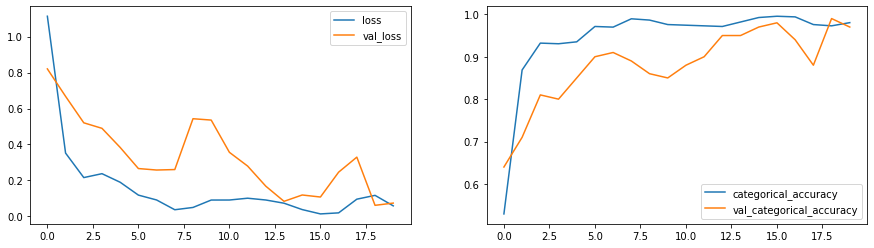

In [24]:
# Train current model 
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot history
plot(history)

With 15 number of sequence also we have managed to build a good model. Model accuracy is high as well as lesser input sequence.

# Consolidated Final Models

Based upon above experiments, We have selected one model each from CNN-3D and CNN-RNN, Let's check these performance

In [25]:
# import libraries required 
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

import time

#### take validation dataset

In [26]:
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 16

val_path = '/home/datasets/Project_data/val'

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# validation sequences = 100


### Generator

In [27]:
# data generator function
def test_generator(source_path, folder_list, batch_size, target_witdth, target_height, img_idx):
    
    if img_idx is None:
        print("Image index not define")
        return None
    
    if (target_witdth <= 0) or ( target_height <= 0):
        print("Image dimenson is  not correct")
        return None
        
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        
        x = len(img_idx) # the number of images you use for each video
        y = target_height # height of image
        z = target_witdth # width of image
            
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    # read Image and conevrt to float
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = resize(image,(y,z,3))
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the image
                                        
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # get left over data
        batch_size_left = int(len(folder_list) % batch_size)
        batch = num_batches
        
        # if there is left over data form a batch
        if batch_size_left > 0:
            # write the code for the remaining data points which are left after full batches
            batch_data = np.zeros((batch_size_left,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size_left,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size_left): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    # read Image and conevrt to float
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized=resize(image,(y,z,3))

                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


#### 1. Conv3D Model
**6th Model with train accuracy 83% and Validation Accuracy 80%, epoch no 19**

**Note : Name of the model is dependent on time and date, so before loading the model make sure the path is correct**

In [28]:
name_model_1 = "model_cnn3D_6_2022-11-1415_47_45.769157/model-00019-0.45443-0.83032-0.56978-0.80000.h5"

### Lets check model details

In [29]:
# load model
model_1 = tf.keras.models.load_model(name_model_1)
# Show the model architecture
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 8, 60, 60, 16)     0         
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 60, 60, 64)     27712     
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 4, 30, 30, 64)    0         
 g3D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 4, 30, 30, 64)    

#### 2. CNN-RNN model
**13th Model with train accuracy 98% and Validation Accuracy 97%, epoch no 15**

In [34]:
name_model_2 = "model_rnn_cnn_13_2022-11-1500_50_41.224356/model-00020-0.05898-0.98039-0.07431-0.97000.h5"

**Lets check model details**

In [35]:
# load model
model_2 = tf.keras.models.load_model(name_model_2)
# Show the model architecture
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  (None, 15, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 15, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 15, 1024)         0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 15, 1024)        

#### Since 2nd model using mobilenet lets check architecture of mobile net 

In [36]:
# import 
from tensorflow.keras.applications import mobilenet
# load model
mobilenet_trns = mobilenet.MobileNet(weights='imagenet', include_top=False)
#print summary
mobilenet_trns.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                         

#### Compare network parameter
**Model_1 : Total Parameter-   574,693  : Layers - 4 Conv3d, 1 dense, 1 output**

**Model_2 : Total Parameter- 3,684,677  : Layers - 14 Conv2d, 13 DepthwiseConv2D, GRU 1, Dense 1, output 1**

### Lets profile the model

In [37]:
# input shape and num of frmaes to be picked
ImageWidth = 120
ImageHeight = 120

In [38]:
img_idx_1 = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,29]
test_data_generator_1 = test_generator(val_path, val_doc, batch_size, ImageWidth, ImageHeight, img_idx_1)

In [39]:
img_idx_2 = np.arange(0,30,2)
test_data_generator_2 = test_generator(val_path, val_doc, batch_size, ImageWidth, ImageHeight, img_idx_2)

#### profile Model 1

In [40]:
start = time.time()
loss, acc = model_1.evaluate(test_data_generator_1, steps=100)
end = time.time()
print("Total   % s seconds" % (end - start))
print("Average % s seconds" % ((end - start)/100))

100/100 [==============================] - 172s 2s/step - loss: 0.6595 - categorical_accuracy: 0.7912
Total   176.35825300216675 seconds
Average 1.7635825300216674 seconds


#### profile Model 2

In [41]:
start = time.time()
loss, acc = model_2.evaluate(test_data_generator_2, steps=100)
end = time.time()
print("Total   % s seconds" % (end - start))
print("Average % s seconds" % ((end - start)/100))

100/100 [==============================] - 162s 2s/step - loss: 0.0975 - categorical_accuracy: 0.9700
Total   166.37716245651245 seconds
Average 1.6637716245651246 seconds


### Compare results:

**Clearly cnn+rnn model is faster and more accurate**

# Result

**Based upon above comparision model_2 is better in terms of Accuracy, Model 2 is faster than model 1. Though model 1 is simpler have lesser parameter than model 2. We are selecting Model 2 as our final model based upon Accuracy and Speed.**

#### Let's load the final model and do one evalution on validation set 

In [45]:
final_model = "model_rnn_cnn_13_2022-11-1500_50_41.224356/model-00020-0.05898-0.98039-0.07431-0.97000.h5"

In [46]:
# input shape and num of frmaes to be picked
ImageWidth = 120
ImageHeight = 120
img_idx = np.arange(0,30,2)
test_data_generator = test_generator(val_path, val_doc, batch_size, ImageWidth, ImageHeight, img_idx)

In [47]:
# load model
new_model = tf.keras.models.load_model(final_model)
# Show the model architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  (None, 15, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 15, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 15, 1024)         0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 15, 1024)        

In [48]:
# Test model
loss, acc = new_model.evaluate(test_data_generator, steps=100)
print('Final model, accuracy: {:5.2f}%'.format(100 * acc))

100/100 [==============================] - 169s 2s/step - loss: 0.0958 - categorical_accuracy: 0.9707
Final model, accuracy: 97.07%
